In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

### Загрузим подготовленные данные из ноутбука data.ipynb

In [3]:
df = pd.read_csv('prepared_data.csv')
df

,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,FCVC,CAEC,CH2O,FAF,TUE,CALC,Age,Height,Weight,NCP,NObeyesdad
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0,1,0,21.000000,1.620000,64.000000,3.0,Normal_Weight
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2,1,2,3,0,1,21.000000,1.520000,56.000000,3.0,Normal_Weight
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,2,1,2,23.000000,1.800000,77.000000,3.0,Normal_Weight
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1,1,2,0,2,27.000000,1.800000,87.000000,3.0,Overweight_Level_I
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0,0,1,22.000000,1.780000,89.800000,1.0,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,1,2,1,1,20.976842,1.710730,131.408528,3.0,Obesity_Type_III
2107,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,1,1,1,1,21.982942,1.748584,133.742943,3.0,Obesity_Type_III
2108,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,1,1,1,1,22.524036,1.752206,133.689352,3.0,Obesity_Type_III
2109,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,2,1,1,1,24.361936,1.739450,133.346641,3.0,Obesity_Type_III


In [4]:
x = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, stratify=y)

### Строим базовую модель логистической регрессии

In [5]:
def make_model(pipeline, x, y):
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_pred_cv_full = cross_val_predict(estimator=pipeline, 
                                   X=x, 
                                   y=y, 
                                   cv=stratified_kfold, 
                                   n_jobs=-1)

    print("Classification Report - Full Model CV:")
    print(classification_report(y_train, y_pred_cv_full, target_names=y.unique()))

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_train, y_pred_cv_full), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Full Model CV')
    plt.show()

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Overweight_Level_II       0.86      0.98      0.91       204
 Overweight_Level_I       0.86      0.67      0.75       215
Insufficient_Weight       0.91      0.86      0.88       263
     Obesity_Type_I       0.92      0.98      0.95       223
    Obesity_Type_II       0.98      1.00      0.99       243
      Normal_Weight       0.76      0.78      0.77       217
   Obesity_Type_III       0.75      0.77      0.76       218

           accuracy                           0.86      1583
          macro avg       0.86      0.86      0.86      1583
       weighted avg       0.86      0.86      0.86      1583



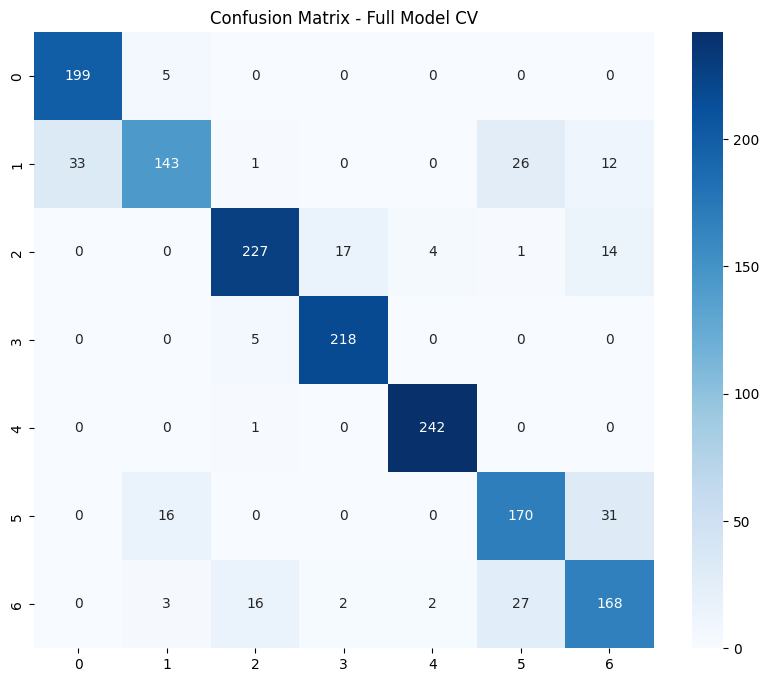

In [6]:
pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(random_state=42)
    )
make_model(pipeline, X_train, y_train)

### Сделаем подбор гиперпараметров с помощью GridSearch

In [10]:
pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(random_state=42)
    )

param_grid = [{
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logisticregression__solver': ['saga', 'lbfgs', 'newton-cg', 'sag'],
    'logisticregression__class_weight': [None, 'balanced', {0: 1, 1: 5}]
}]

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)

Лучшие параметры: {'logisticregression__C': 1000, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}
Лучшая точность: 0.9569806535448745


c:\Users\aaksenov\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
1260 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aaksenov\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aaksenov\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\User

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Overweight_Level_II       0.95      0.98      0.96       204
 Overweight_Level_I       0.96      0.93      0.94       215
Insufficient_Weight       0.98      0.95      0.97       263
     Obesity_Type_I       0.98      0.99      0.98       223
    Obesity_Type_II       0.98      1.00      0.99       243
      Normal_Weight       0.92      0.93      0.93       217
   Obesity_Type_III       0.92      0.92      0.92       218

           accuracy                           0.96      1583
          macro avg       0.96      0.96      0.96      1583
       weighted avg       0.96      0.96      0.96      1583



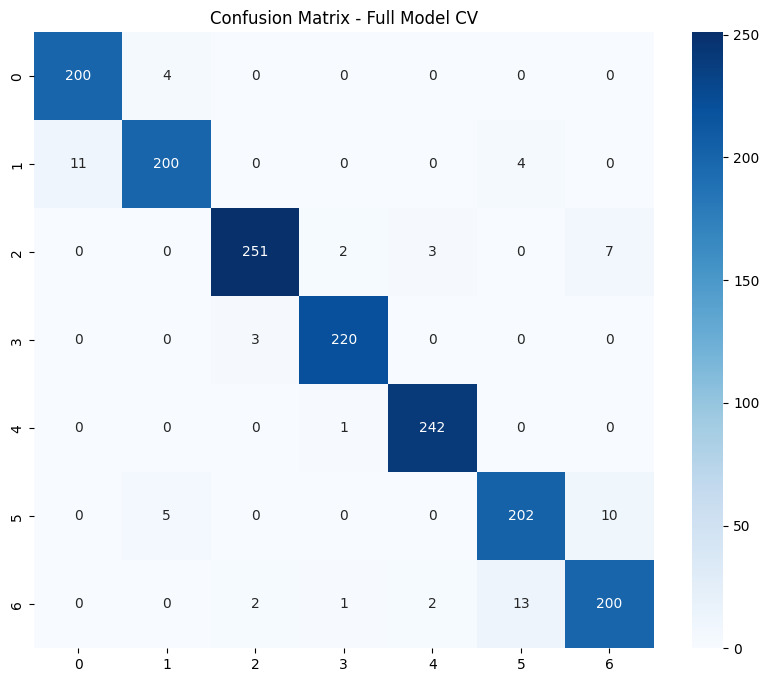

In [12]:
pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(C = 1000, class_weight='balanced', penalty='l2', solver='newton-cg', random_state=42)
    )
make_model(pipeline, X_train, y_train)

### Теперь попробуем использовать полиномы в логистической регрессии

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Overweight_Level_II       0.87      0.92      0.90       204
 Overweight_Level_I       0.79      0.72      0.75       215
Insufficient_Weight       0.92      0.92      0.92       263
     Obesity_Type_I       0.97      0.97      0.97       223
    Obesity_Type_II       0.98      1.00      0.99       243
      Normal_Weight       0.81      0.82      0.81       217
   Obesity_Type_III       0.84      0.84      0.84       218

           accuracy                           0.89      1583
          macro avg       0.88      0.88      0.88      1583
       weighted avg       0.89      0.89      0.89      1583



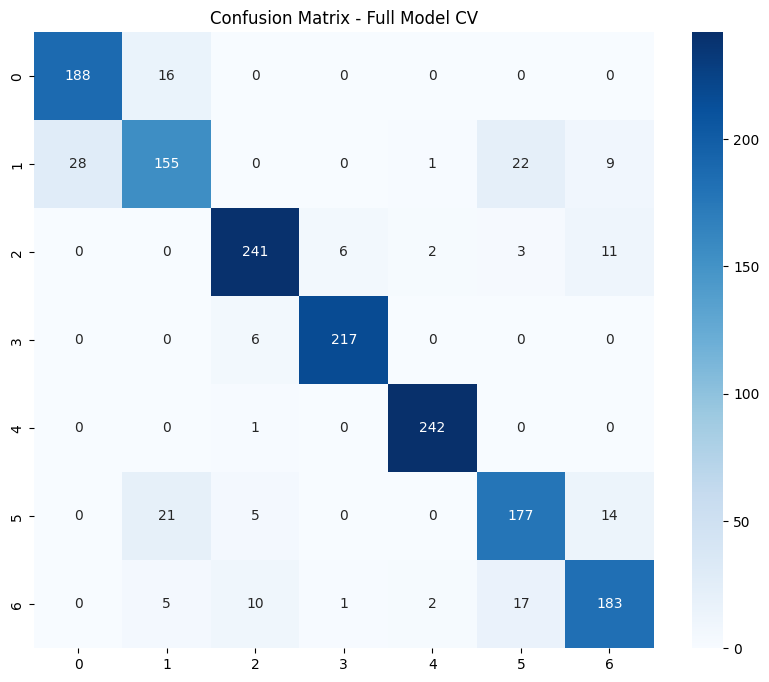

In [13]:
pipeline = make_pipeline(
        PolynomialFeatures(),
        StandardScaler(),
        LogisticRegression(random_state=42)
    )
make_model(pipeline, X_train, y_train)

In [14]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = [{
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs'],
    'clf__class_weight': [None, 'balanced'],
    'poly__degree': [2, 3],
    'poly__interaction_only': [True, False]
}]

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)

Лучшие параметры: {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'poly__degree': 2, 'poly__interaction_only': False}
Лучшая точность: 0.9023603538272363


c:\Users\aaksenov\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
1400 fits failed out of a total of 2520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
560 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aaksenov\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aaksenov\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\User

### Построим модель для лучшего предсказания для полиномиальной логистической регрессии

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Overweight_Level_II       0.88      0.93      0.90       204
 Overweight_Level_I       0.78      0.73      0.76       215
Insufficient_Weight       0.96      0.93      0.94       263
     Obesity_Type_I       1.00      0.97      0.98       223
    Obesity_Type_II       0.98      0.99      0.99       243
      Normal_Weight       0.84      0.85      0.85       217
   Obesity_Type_III       0.86      0.89      0.87       218

           accuracy                           0.90      1583
          macro avg       0.90      0.90      0.90      1583
       weighted avg       0.90      0.90      0.90      1583



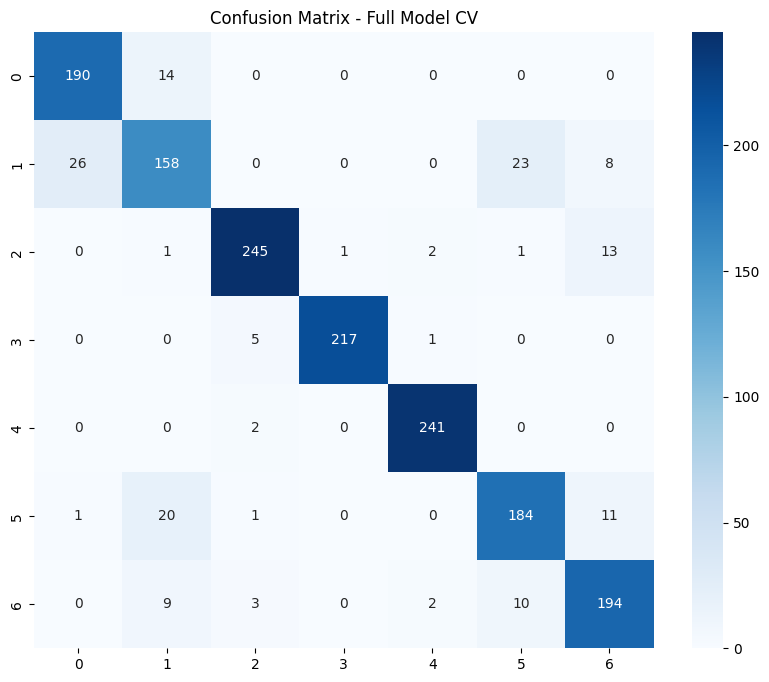

In [15]:
pipeline = make_pipeline(
        PolynomialFeatures(interaction_only=False, include_bias=False, degree=2),
        StandardScaler(),
        LogisticRegression(C = 10, class_weight='balanced', penalty='l2', solver='lbfgs', random_state=42)
    )
make_model(pipeline, X_train, y_train)

### Видим, что для обычной логистической регрессии без применения полиномов модель дает лучший результат, причем довольно больше